In [1]:
import numpy as np
import pandas as pd

In [2]:
from datetime import datetime

current_time = datetime.now().strftime("%H:%M:%S")
print("Time started =", current_time)

Time started = 15:52:27


In [3]:
data = pd.read_csv("train.csv")

# EDA

In [4]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.shape

(7613, 5)

## Initial cleanup

### Handling NaNs

In [6]:
def na_counts(df):
    na_columns = df.columns[df.isna().any()]
    if len(na_columns)==0:
        return 0
    return df[na_columns].isna().apply(lambda x: x.value_counts())

In [7]:
na_counts(data)

,keyword,location
False,7552,5080
True,61,2533


In [8]:
data = data.fillna("")

In [9]:
na_counts(data)

0

## Exploring variables

In [10]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

### Target value counts

0    4342
1    3271
Name: target, dtype: int64


([<matplotlib.patches.Wedge at 0x7f136d9e5600>,
 [Text(-0.24110481617711207, 1.0732513534192263, '0'),
  Text(0.24110481617711216, -1.0732513534192263, '1')])

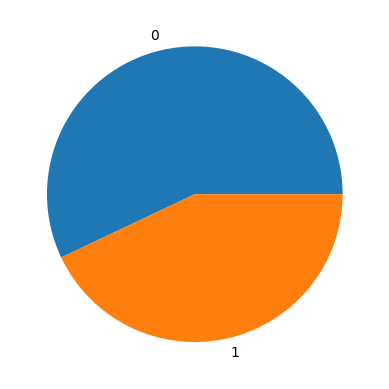

In [11]:
print(data.target.value_counts())
plt.pie(data.target.value_counts(), labels = (0,1))

In [12]:
def sorted_corr_coefs(df, column_name, target_column_name):
    dv = DictVectorizer(sparse=False)
    dict = data[[column_name]].to_dict(orient='records')
    columns = np.transpose(dv.fit_transform(dict))
    corrcoefs = []
    for col in columns:
        corrcoefs.append(np.corrcoef(col, data[target_column_name])[0, 1])
    named_list = list(zip(dv.get_feature_names_out(), corrcoefs))
    named_list.sort(key=lambda tup: tup[1], reverse = True)
    return named_list

In [13]:
# Analyzing mutual info score I want to compare it with such of a shuffled data
shuffled_target = data.target.sample(frac=1, random_state=10)

### Variable "keyword"

In [14]:
data.keyword.value_counts()

                         61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [15]:
mutual_info_score(data['keyword'], data['target']), mutual_info_score(data['keyword'], shuffled_target)

(0.16947295623391556, 0.013396592412637555)

In [16]:
sorted_corr_coefs(data, "keyword", "target")[:10], sorted_corr_coefs(data, "keyword", "target")[-10:]

([('keyword=derailment', 0.08267501656791963),
  ('keyword=wreckage', 0.08267501656791963),
  ('keyword=debris', 0.080516616503906),
  ('keyword=outbreak', 0.08006342865745676),
  ('keyword=typhoon', 0.07783761510564755),
  ('keyword=oil%20spill', 0.0778376151056471),
  ('keyword=suicide%20bombing', 0.07198080078232648),
  ('keyword=suicide%20bomber', 0.0695037416094893),
  ('keyword=suicide%20bomb', 0.06653252563655127),
  ('keyword=rescuers', 0.06653252563655115)],
 [('keyword=explode', -0.05017903198569013),
  ('keyword=wrecked', -0.05113178663476735),
  ('keyword=traumatised', -0.05114149168021993),
  ('keyword=screaming', -0.05209138226332336),
  ('keyword=electrocute', -0.05228924767605569),
  ('keyword=body%20bag', -0.053229704823294664),
  ('keyword=blazing', -0.05415435078089598),
  ('keyword=ruin', -0.05684086013528472),
  ('keyword=aftershock', -0.05813382079078929),
  ('keyword=body%20bags', -0.060242258664847156)])

### Variable "location"

In [17]:
data.location.value_counts()

                                2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

In [18]:
mutual_info_score(data['location'], data['target']), mutual_info_score(data['location'], shuffled_target)

(0.31254635681695697, 0.30151620936968093)

In [19]:
sorted_corr_coefs(data, "location", "target")[:10], sorted_corr_coefs(data, "location", "target")[-10:]

([('location=USA', 0.05101140011993961),
  ('location=Mumbai', 0.047195302822488135),
  ('location=India', 0.045857912019408635),
  ('location=Nigeria', 0.043700694813182915),
  ('location=Washington, DC', 0.030239642046364305),
  ('location=Bend, Oregon', 0.026416230235620966),
  ('location=Nairobi-KENYA', 0.02641623023562073),
  ('location=Calgary', 0.026416230235620723),
  ('location=Nigeria ', 0.02641623023562072),
  ('location=Portland, Oregon', 0.02641623023562072)],
 [('location=Coventry', -0.022250773490737206),
  ('location=Texas, USA', -0.02225077349073725),
  ('location=Indiana', -0.02225077349073729),
  ('location=Wisconsin', -0.02225077349073729),
  ('location=ss', -0.024151501376051914),
  ('location=London, England', -0.024151501376051928),
  ('location=Morioh, Japan', -0.024376103182953163),
  ('location=Pennsylvania, USA', -0.026330931421991832),
  ('location=304', -0.029860396014459598),
  ('location=New York', -0.04004435015466763)])

### Variable "text"

In [20]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
count_vectorizer = CountVectorizer()
vectors = count_vectorizer.fit_transform(data['text'])
vectors.shape

(7613, 21637)

In [22]:
frequencies = list(zip(count_vectorizer.get_feature_names_out(), vectors[0].todense().getA()[0]))
[x for x in frequencies if x[1] > 0], data.text[0]

([('all', 1),
  ('allah', 1),
  ('are', 1),
  ('deeds', 1),
  ('earthquake', 1),
  ('forgive', 1),
  ('may', 1),
  ('of', 1),
  ('our', 1),
  ('reason', 1),
  ('the', 1),
  ('this', 1),
  ('us', 1)],
 'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all')

#### Hashtags

In [23]:
hashtag_pattern = r'#(\w+)'

hashtags = data.text.str.lower().str.findall(hashtag_pattern)
ht_c_vect = CountVectorizer(min_df=5, analyzer=lambda x: x)
ht_vectors = ht_c_vect.fit_transform(hashtags)
ht_c_vect.get_feature_names_out(), len(ht_c_vect.get_feature_names_out())

(array(['1', 'abstorm', 'africa', 'afterlife', 'allah', 'animalrescue',
        'antioch', 'armageddon', 'art', 'bb17', 'bbc', 'best',
        'bestnaijamade', 'beyhive', 'breaking', 'business', 'california',
        'cnn', 'course', 'dance', 'directioners', 'disaster', 'dnb',
        'drought', 'dubstep', 'earthquake', 'edm', 'emergency',
        'emmerdale', 'fashion', 'fukushima', 'gbbo', 'genocide', 'god',
        'hailstorm', 'handbag', 'hiring', 'hiroshima', 'hot', 'ices',
        'india', 'iphone', 'irandeal', 'isis', 'islam', 'japan', 'job',
        'jobs', 'kerricktrial', 'kindle', 'landslide', 'lgbt', 'libya',
        'lies', 'mh370', 'military', 'mtvhottest', 'mumbai', 'myanmar',
        'news', 'newyork', 'nowplaying', 'np', 'nuclear', 'nursing',
        'okwx', 'pakistan', 'pantherattack', 'phoenix', 'photography',
        'prebreak', 'preparedness', 'prophetmuhammad', 'quote', 'quran',
        'refugees', 'rohingya', 'rt', 'science', 'seattle', 'sismo',
        'sittwe', 

In [24]:
data['hashtags'] = hashtags
data

,id,keyword,location,text,target,hashtags
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,4,,,Forest fire near La Ronge Sask. Canada,1,[]
2,5,,,All residents asked to 'shelter in place' are ...,1,[]
3,6,,,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,[]
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,[]
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[]
7611,10872,,,Police investigating after an e-bike collided ...,1,[]


#### URLs

In [25]:
count_vectorizer.get_feature_names_out()[0:100]

array(['00', '000', '0000', '007npen6lg', '00cy9vxeff', '00end', '00pm',
       '01', '02', '0215', '02elqlopfk', '02pm', '03', '030', '033',
       '034', '039', '03l7nwqdje', '04', '05', '05th', '06', '060', '061',
       '06jst', '07', '073izwx0lb', '08', '0840728', '0853',
       '087809233445', '0880', '08lngclzsj', '09', '0abgfglh7x',
       '0ajisa5531', '0blkwcupzq', '0btniwagt1', '0bvk5tub4j',
       '0c1y8g7e9p', '0cr74m1uxm', '0cxm5tkz8y', '0dqjeretxu',
       '0drqlrsgy5', '0dxvz7fdh3', '0erisq25kt', '0f8xa4ih1u',
       '0fekgyby5f', '0fs9ksv5xk', '0ghk693egj', '0gidg9u45j',
       '0gknpy4lua', '0h7oua1pns', '0iw6drf5x9', '0iyuntxduv',
       '0jfnvaxfph', '0jmkdtcymj', '0kccg1bt06', '0keh2treny',
       '0krw1zyahm', '0l', '0la1aw9uud', '0llwuqn8vg', '0lmheaex9k',
       '0lpu0gr2j0', '0m1tw3datd', '0mcxc68gzd', '0migwcmtje',
       '0mnpcer9no', '0npzp', '0nr4dpjgyl', '0oms8ri3l1', '0pamznyyuw',
       '0q040stkcv', '0r03c6njli', '0rny349unt', '0rokdutyun',
       '0rsv

In [26]:
data.loc[data['text'].str.contains("0cxm5tkz8y", case=False)].text.values[0]

'Sharp rise in women children casualties in Afghan war UN says http://t.co/0CXm5TkZ8y http://t.co/v5aMDOvHOT'

In [27]:
url_pattern =  r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'

In [28]:
data.text[data.text.str.findall(url_pattern).apply(len) > 0].values

array(['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
       'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
       '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
       ...,
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [29]:
data.text.str.findall(url_pattern).apply(lambda x: x[0] if len(x) > 0 else None).shape

(7613,)

Let's observe correlation of different words with target

In [30]:
columns = np.transpose(vectors.todense().A)
columns.shape

(21637, 7613)

In [31]:
corrcoefs = []
for col in columns:
    corrcoefs.append(np.corrcoef(col, data.target)[0, 1])
named_list = list(zip(count_vectorizer.get_feature_names_out(), corrcoefs))
named_list.sort(key=lambda tup: tup[1], reverse = True)

In [32]:
named_list[0:10], named_list[-10:]

([('http', 0.2126857016032362),
  ('co', 0.19584656255519792),
  ('in', 0.16485584681394716),
  ('california', 0.1304433035954872),
  ('suicide', 0.12401359099263466),
  ('hiroshima', 0.12057003953828943),
  ('killed', 0.11927123983117018),
  ('mh370', 0.1095485856349991),
  ('wildfire', 0.1062656731133471),
  ('northern', 0.10608400609185162)],
 [('if', -0.0686682762655394),
  ('can', -0.07132110403337122),
  ('it', -0.07247470509376949),
  ('full', -0.0730178581511043),
  ('so', -0.07517673569508387),
  ('your', -0.07672163676999283),
  ('body', -0.08359410507385581),
  ('me', -0.08871342288840284),
  ('my', -0.12872670360280616),
  ('you', -0.15300123086640835)])

#### Emoji

In [33]:
import emoji

In [34]:
print(data.text.apply(emoji.distinct_emoji_list)[data.text.apply(emoji.emoji_count) > 0])

2171    [©]
2172    [©]
2173    [©]
2179    [©]
3479    [©]
4390    [©]
7127    [©]
7514    [©]
7527    [©]
7532    [©]
Name: text, dtype: object


# Training Models

## Plan

We are going to try various data preparation and transformation steps and try them on several different classification models.
The whole pipeline will be as follows:

1. Data Preparation
    1. CountVectorizer applied to the `text` column as central part of preparation
    1. Additional steps:
        1. Cleanup URLs from text
        1. `keyword` column vectorization
        1. `location` column vectorization
        1. The newly created `hashtags` column vectorization
        1. Using stopwords
        1. Stemming
        1. Lemmatization
        1. ngrams
    1. By end of this stage we'll get a sparce matrix of vectors, that could be fed into different models. Testing different combinations we'll find the best steps for each model
1. Data transformation and dimensionality reduction
    1. The following techniques will be performed on the data from the previous stage:
        1. Polynomialization
        1. SelectKBest
        1. TruncatedSVD
    1. GridSearchCV will be used to find the most winning sequence
1. Final Models Parameters Tuning
    1. Each model with it's optimal data pipeline will be run through hyperparameter tuning
1. Testing with test data

### Data Preparation Helpers

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import scipy.sparse as sp
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest, chi2

In [36]:
import nltk

In [37]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/iliav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/iliav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/iliav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/iliav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [38]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet

from sklearn.preprocessing import FunctionTransformer
import re

In [39]:
stopwords_english = stopwords.words('english')
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def pos_for_tag(tag):
        if tag.startswith('V'):
            return 'v'
        elif tag.startswith('J'):
            return('a')
        elif tag.startswith('R'):
            return('r')
        else:
            return('n')
        
def lemma_preprocessor_full(text):
    words=[lemmatizer.lemmatize(w, pos_for_tag(tag)) for w, tag in pos_tag(re.split("\\s+",text))]
    return ' '.join(words)

def lemma_preprocessor_verb(text):
    words=[lemmatizer.lemmatize(w, 'v') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_adj(text):
    words=[lemmatizer.lemmatize(w, 'a') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_adverb(text):
    words=[lemmatizer.lemmatize(w, 'r') for w in re.split("\\s+",text)]
    return ' '.join(words)

def lemma_preprocessor_noun(text):
    words=[lemmatizer.lemmatize(w, 'r') for w in re.split("\\s+",text)]
    return ' '.join(words)

def stem_preprocessor(text):
    words=[stemmer.stem(w) for w in re.split("\\s+",text)]
    return ' '.join(words)

In [40]:
def url_clean(df):
    df = df.copy()
    df.text = df.text.replace(url_pattern, '', regex=True)
    return df

url_cleaner = FunctionTransformer(url_clean)

In [41]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_full_train.shape, df_test.shape

((6090, 6), (1523, 6))

In [42]:
settings = {
    'preprocessors' : [('None', None)],
    'stopwords' : [('None', None)],
    'ngram_ranges' : [('1_1', (1, 1))],
    'best_ks' : [('1000', 1000)]
}

In [43]:
small_train, small_test = train_test_split(data, test_size=0.9, random_state=42)
small_train.shape, small_test.shape

X_full_train = small_train.drop('target', axis=1)
y_full_train = small_train.target

In [44]:
X_full_train = df_full_train.drop('target', axis=1)
y_full_train = df_full_train.target

X_test = df_test.drop('target', axis=1)
y_test = df_test.target

cv = model_selection.StratifiedKFold(4, shuffle=True, random_state=55)

In [45]:
%load_ext autoreload
%autoreload 2

In [46]:
from preprocess_util import prepare_train_data, prepare_test_vectors, default_preprocess_settings, prepare_cross_val_vectors, my_cross_val_score

### Steps combinations

In [47]:
%time
isolated_steps_settings = {
    'Pure Text': {},
    'Url Cleaner': {'url_cleaner': url_cleaner},
    'Stemming': {'preprocessor': stem_preprocessor},
    'Lemmatization': {'preprocessor': lemma_preprocessor_full},
    'Keyword': {'kw': True},
    'Location': {'loc': True},
    'Hashtags': {'hashtags': True},    
    'Stopwords': {'stopwords': stopwords_english},    
    '1-2 words ngrams': {'ngram_range': (1, 2)},
    '1-3 words ngrams': {'ngram_range': (1, 3)},

    'Stopwords + Stemming': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor},  
    'Stopwords + Lemmatization': {'stopwords': stopwords_english, 'preprocessor': lemma_preprocessor_full},
    'Keyword + URL Cleaner': {'url_cleaner': url_cleaner, 'kw': True},
    'Keyword + Stemming': {'url_cleaner': url_cleaner, 'preprocessor': stem_preprocessor},
    'Stopwords + URL Cleaner': {'stopwords': stopwords_english, 'url_cleaner': url_cleaner},
    'Stopwords + Keyword': {'stopwords': stopwords_english, 'kw': True},
    'Stopwords + Location': {'stopwords': stopwords_english, 'loc': True},
    'Stopwords + Hashtags': {'stopwords': stopwords_english, 'hashtags': True},
    'Stopwords + 1-2 ngrams': {'stopwords': stopwords_english, 'ngram_range': (1, 2)},
    'Stopwords + Stemming + Keyword': {'stopwords': stopwords_english, 'kw': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Location': {'stopwords': stopwords_english, 'Loc': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + Hashtags': {'stopwords': stopwords_english, 'hashtags': True, 'preprocessor': stem_preprocessor},
    'Stopwords + Stemming + URL Cleaner': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'url_cleaner': url_cleaner},
    'Stopwords + Stemming + 1-2 ngrams': {'stopwords': stopwords_english, 'preprocessor': stem_preprocessor, 'ngram_range': (1, 2)}
}

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


In [48]:
%%time

isolated_steps_vectors = {}
for key, step_settings in isolated_steps_settings.items():
    # print(f"Processing {key}")
    settings = default_preprocess_settings.copy()
    settings.update(step_settings)
    isolated_steps_vectors[key] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=settings)

CPU times: user 55.9 s, sys: 400 ms, total: 56.3 s
Wall time: 56.3 s


In [49]:
def default_settings_updated(settings_update):
    settings = default_preprocess_settings.copy()
    settings.update(settings_update)
    return settings

In [50]:
isolated_steps_vectors['Keyword + Location'] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, 
                                                                         settings=default_settings_updated({'kw': True, 'loc': True})) #forest
isolated_steps_vectors['Keyword + Hashtags'] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, 
                                                                         settings=default_settings_updated({'kw': True, 'hashtags': True})) #logistic regression
isolated_steps_vectors['Keyword + location + Hashtags'] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, 
                                                                         settings=default_settings_updated({'kw': True, 'hashtags': True, 'Loc': True})) #XGBoost

In [51]:
isolated_steps_vectors['Keyword + Location + Stemming'] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, 
                                                                         settings=default_settings_updated(
                                                                             {'kw': True, 
                                                                              'Loc': True,
                                                                              'preprocessor': stem_preprocessor})) #Forest

In [52]:
isolated_steps_vectors['Keyword + Location + Hashtags + Stemming'] = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, 
                                                                         settings=default_settings_updated(
                                                                             {'kw': True, 
                                                                              'hashtags': True, 
                                                                              'Loc': True,
                                                                              'preprocessor': stem_preprocessor})) #Forest

### List of models

In [53]:
scale_pos_weight = y_full_train.value_counts()[0] / y_full_train.value_counts()[1]

In [54]:
model_nb = ComplementNB() #This Naive Bayes classifier is meant to work well with imbalanced data sets
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=500, random_state=42, class_weight="balanced")
model_tree = DecisionTreeClassifier(max_depth=7, class_weight="balanced")
model_forest = RandomForestClassifier(n_estimators=50,
                            max_depth=7,
                            min_samples_leaf=2,
                            random_state=42, 
                            class_weight="balanced")
model_xgb = XGBClassifier(learning_rate=0.2,
                          n_estimators=10, 
                          max_depth=7, 
                          min_child_weight=1, 
                          objective="binary:logistic", 
                          scale_pos_weight=scale_pos_weight, 
                          seed=42)

In [55]:
from preprocess_util import compare_models

## Data Preparation

### Steps evaluation

In [56]:
def evaluate_models(models, best_settings=None, feature_key=None):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, model in models.items():
        settings = best_settings[model_key] if best_settings else default_preprocess_settings
        
        vectors = prepare_cross_val_vectors(X_full_train, y_full_train, cv=cv, settings=settings)
        score = my_cross_val_score(model, vectors['splits']).mean()

        full_train_data = prepare_train_data(X_full_train, y_full_train, settings=settings)
        test_vectors = prepare_test_vectors(X_test, full_train_data)

        model.fit(full_train_data['vectors'], y_full_train)
        test_score = f1_score(model.predict(test_vectors), y_test)

        record_dict[model_key] = score
        test_record_dict[model_key] = test_score    
    scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [57]:
%%time
nb_key = 'Naive Bayes'
rc_key = 'Ridge Classifier'
lr_key = 'Logistic Regression'
tree_key = 'Tree'
forest_key = 'Forest'
xgb_key = 'XGBoost'

simple_models = {
        nb_key: model_nb,
        rc_key: model_rc,
        lr_key: model_lr,
        tree_key: model_tree,
        forest_key: model_forest,
        xgb_key: model_xgb
    }

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


In [58]:
default_scores_df = evaluate_models(simple_models, feature_key='Text only')

In [59]:
default_scores_df

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Text only (x_val),0.745691,0.722527,0.750935,0.646926,0.667077,0.662832
Text only (test),0.742496,0.732157,0.758353,0.623988,0.657895,0.667168


In [60]:
simple_comparison_df = compare_models(simple_models, isolated_steps_vectors)

In [61]:
simple_comparison_df

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Pure Text,0.745691,0.722527,0.750935,0.647381,0.667077,0.662832
Url Cleaner,0.749287,0.722742,0.751650,0.497472,0.662749,0.631451
Stemming,0.742193,0.723354,0.743909,0.641448,0.666489,0.678344
Lemmatization,0.732984,0.713045,0.733724,0.634626,0.650094,0.652162
Keyword,0.754322,0.724536,0.752899,0.648752,0.658315,0.665638
Location,0.740761,0.719980,0.748347,0.647420,0.669172,0.662369
Hashtags,0.744042,0.721704,0.751650,0.647811,0.660135,0.663879
Stopwords,0.742480,0.720265,0.743379,0.637731,0.645841,0.662926
1-2 words ngrams,0.736126,0.707925,0.746017,0.645553,0.641048,0.662301


In [62]:
simple_diffs = (simple_comparison_df - simple_comparison_df.loc['Pure Text']).drop('Pure Text')

In [63]:
from preprocess_util import plot_score_diffs

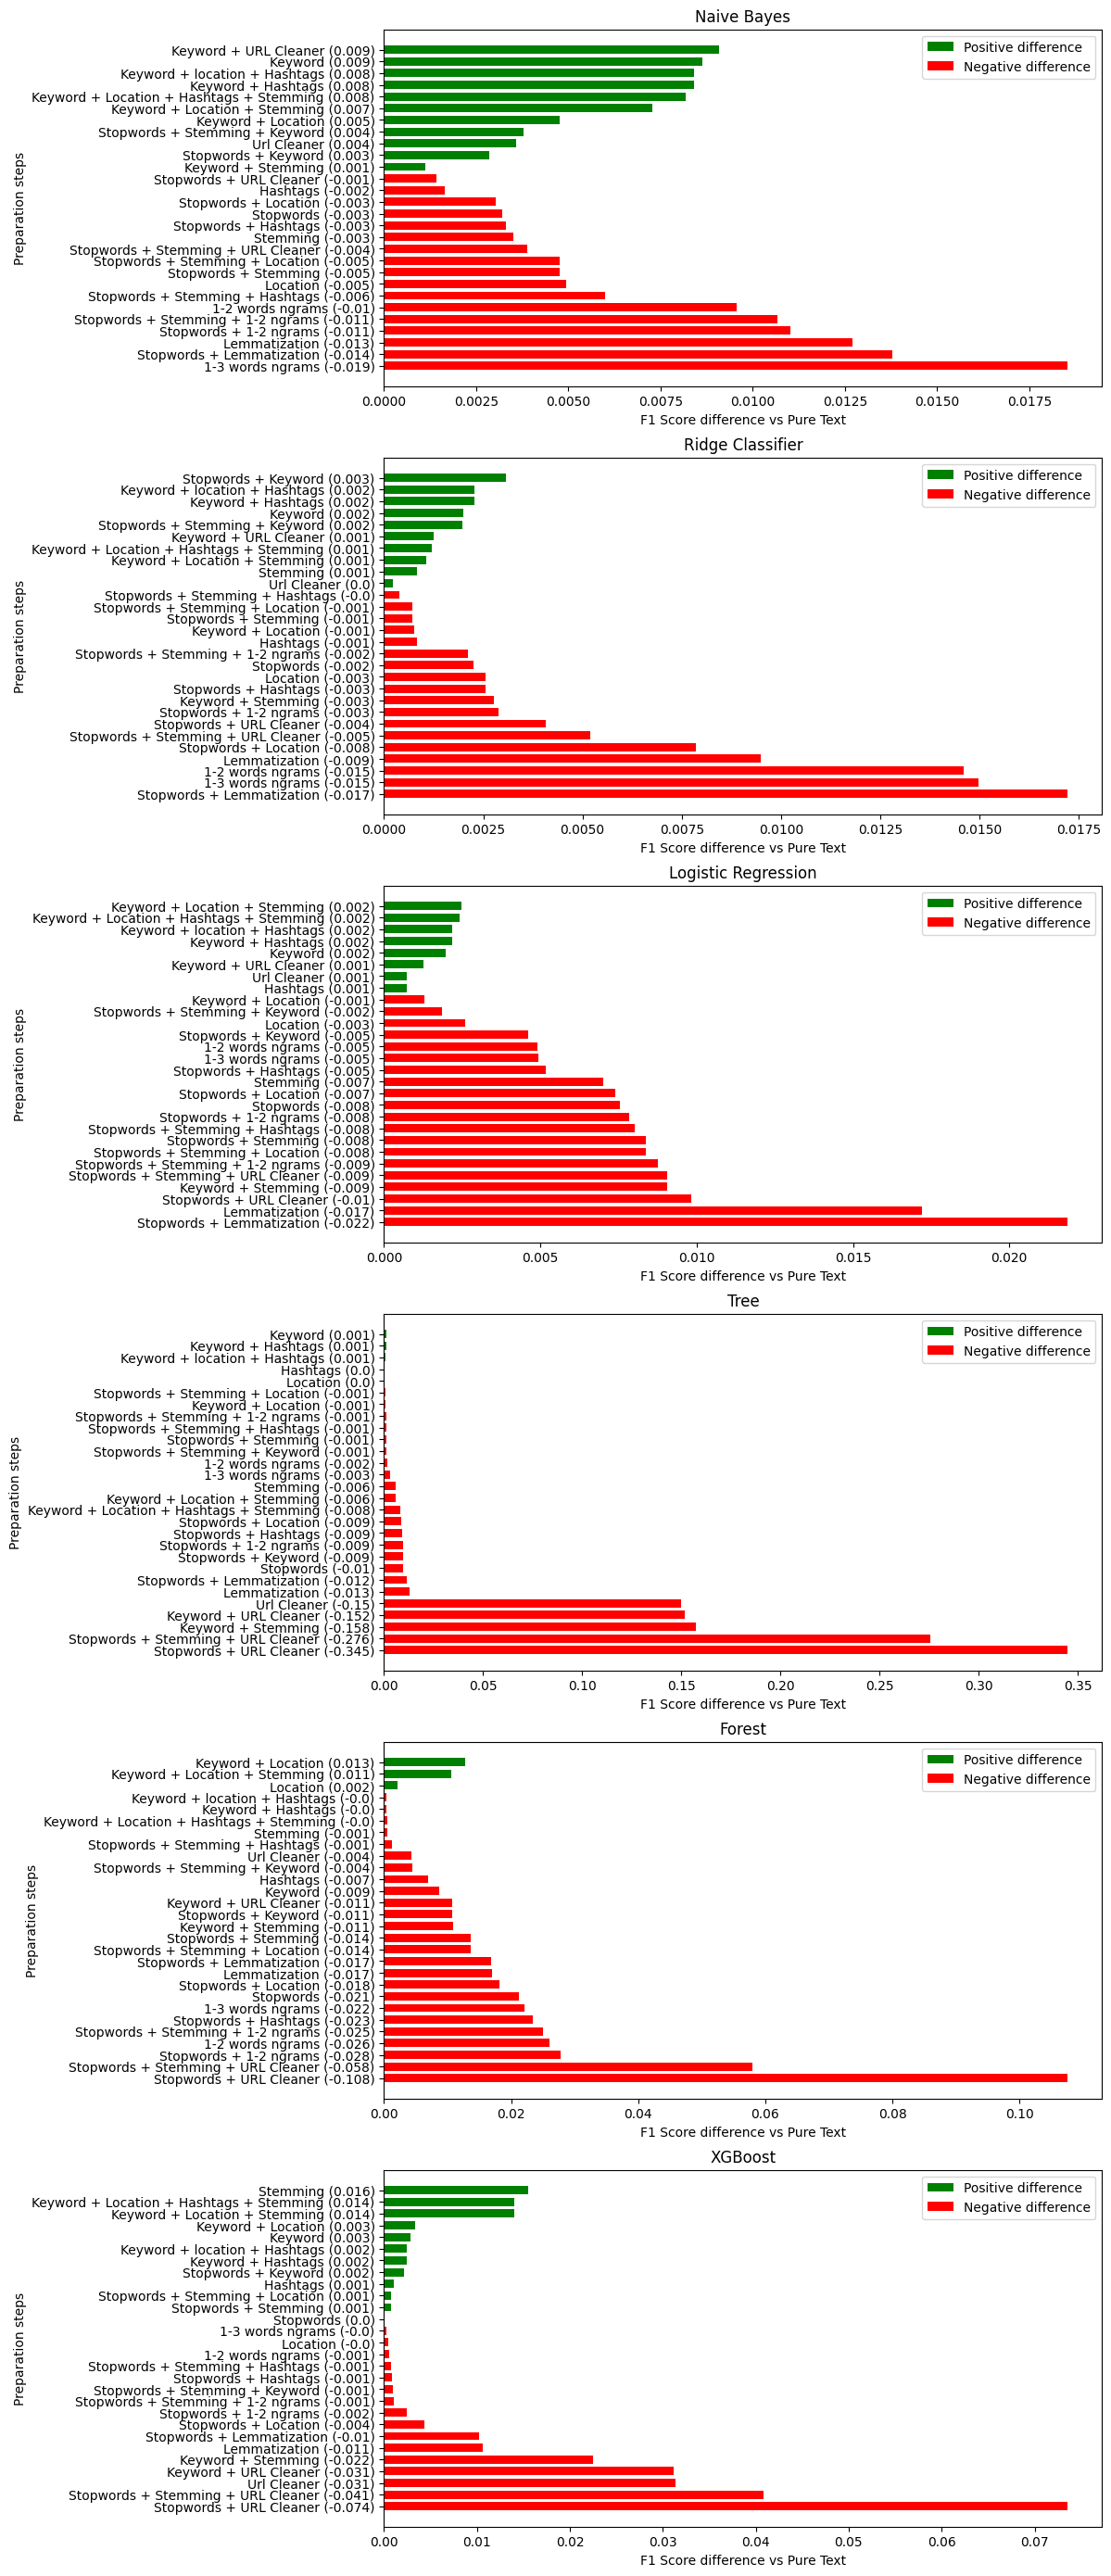

In [64]:
plot_score_diffs(simple_diffs)

One of the most interesting learnings from this data is that different steps that have positive effect on the score when applied separately, have negative effect when combined together. E.g. `keyword` and `stemming` in XGBoost

### Best preparation steps per model

In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def kw_to_dict(series):
    return [{'keyword': item[1]} for item in series.items()]

kw_to_dict_transformer = FunctionTransformer(kw_to_dict)

kw_pipeline = Pipeline(steps=[('kw_to_dict', kw_to_dict_transformer),
                              ('d_vect', DictVectorizer())])

text_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text')])
                                                    
text_kw_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text'),
                                                    ('kw_dict_vect', kw_pipeline, 'keyword')])
text_kw_loc_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text'),
                                                    ('kw_dict_vect', kw_pipeline, 'keyword'),
                                                       ('loc_dict_vect', kw_pipeline, 'location')])
text_hashtags_vectorizer_transformer = ColumnTransformer([('text_c_vect', CountVectorizer(min_df=5), 'text'),
                                                          ('hashtags_c_vect', CountVectorizer(min_df=5, analyzer=lambda x: x), 'hashtags')])

poly2_k_best_pipeline = Pipeline(steps=[('poly2', PolynomialFeatures(2)),
                                        ('k_best', SelectKBest(chi2))])


In [66]:
def make_vectorizer(
        min_df=5, 
        kw=False, 
        loc=False, 
        ht=False,
        stopwords=None,
        preprocessor=None):
    columns = [('text_c_vect', CountVectorizer(min_df=5, stop_words=stopwords, preprocessor=preprocessor), 'text')]
    if kw:
        columns.append(('kw_dict_vect', kw_pipeline, 'keyword'))
    if loc:
        columns.append(('loc_dict_vect', kw_pipeline, 'location'))
    if ht:
        columns.append(('hashtags_c_vect', CountVectorizer(min_df=5, analyzer=lambda x: x), 'hashtags'))
    
    return ColumnTransformer(columns)
    

def make_preparation_pipeline(
        url_cleaner=None,                            
        vectorizer=make_vectorizer()):
    
    steps = [('url_cleaner', url_cleaner)]    
    steps.append(('vectorizer', vectorizer))
    
    return Pipeline(steps=steps)

In [70]:
from sklearn.model_selection import cross_val_score

def evaluate_pipelines(pipelines, feature_key=None):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, pipeline in pipelines.items():
        steps = pipeline.steps.copy()
        steps.append(('classifier', simple_models[model_key]))
        clf_pipeline = Pipeline(steps)
        
        score = cross_val_score(clf_pipeline, X_full_train, y_full_train, scoring='f1', cv=cv).mean()

        clf_pipeline.fit(X_full_train, y_full_train)
        test_score = f1_score(y_test, clf_pipeline.predict(X_test))
        
        record_dict[model_key] = score
        test_record_dict[model_key] = test_score    
    
    scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [68]:
best_pipelines = {}

best_pipelines[nb_key] = make_preparation_pipeline(url_cleaner=url_cleaner, vectorizer=make_vectorizer(kw=True))
best_pipelines[rc_key] = make_preparation_pipeline(vectorizer=make_vectorizer(kw=True, stopwords=stopwords_english))
best_pipelines[lr_key] = make_preparation_pipeline(vectorizer=make_vectorizer(kw=True, loc=True, preprocessor=stem_preprocessor))
best_pipelines[tree_key] = make_preparation_pipeline(vectorizer=make_vectorizer(stopwords=stopwords_english, preprocessor=stem_preprocessor))
best_pipelines[forest_key] = make_preparation_pipeline(vectorizer=make_vectorizer(kw=True, loc=True))
best_pipelines[xgb_key] = make_preparation_pipeline(vectorizer=make_vectorizer(preprocessor=stem_preprocessor))

In [71]:
preparation_scores_df = evaluate_pipelines(best_pipelines, feature_key='Data preparation')

/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'onc', 'onli', 'ourselv', 'themselv', 'veri', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokeni

In [73]:
pd.concat((default_scores_df, preparation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Text only (x_val),0.745691,0.722527,0.750935,0.646926,0.667077,0.662832
Text only (test),0.742496,0.732157,0.758353,0.623988,0.657895,0.667168
Data preparation (x_val),0.754771,0.725599,0.749993,0.645923,0.679897,0.678344
Data preparation (test),0.748019,0.720623,0.760433,0.629888,0.666160,0.673945


In [64]:

best_settings = {}

best_settings[nb_key] =  default_settings_updated({'url_cleaner': url_cleaner, 'kw': True})
best_settings[rc_key] =  default_settings_updated({'kw': True, 'stopwords': stopwords_english})
best_settings[lr_key] =  default_settings_updated({'kw': True, 'loc': True, 'preprocessor': stem_preprocessor})
best_settings[tree_key] =  default_settings_updated({'preprocessor': stem_preprocessor,
                                                   'stopwords': stopwords_english})
best_settings[forest_key] =  default_settings_updated({'kw': True, 'loc': True})
best_settings[xgb_key] =  default_settings_updated({'preprocessor': stem_preprocessor})

preparation_scores_df = evaluate_models(simple_models, best_settings=best_settings, feature_key='Data preparation')

In [65]:
pd.concat((default_scores_df, preparation_scores_df))

,Naive Bayes,Ridge Classifier,Logistic Regression,Tree,Forest,XGBoost
Features,,,,,,
Text only (x_val),0.746288,0.722665,0.751130,0.647543,0.655737,0.662832
Text only (test),0.744260,0.732157,0.758353,0.623988,0.670713,0.667168
Data preparation (x_val),0.755302,0.725309,0.749209,0.645808,0.671624,0.678344
Data preparation (test),0.748019,0.720623,0.761021,0.628931,0.678815,0.673945


## Data Transformation. Polynomialization and Dimensionality Reduction

In [66]:
from preprocess_util import k_range_scores, svd_n_range_scores, plot_k_range_results, plot_svd__range_results

In [189]:
def get_default_pipeline():
    return Pipeline(steps=[('url_cleaner', url_cleaner),
                                    ('vectorizer', text_kw_vectorizer_transformer),
                                    ('poly2_k_best', poly2_k_best_pipeline),
                                    ('svd', TruncatedSVD()),
                                    ('classifier', model_nb)])

### Naive Bayes

In [69]:
default_preprocess_settings

{'url_cleaner': None,
 'preprocessor': None,
 'stopwords': None,
 'ngram_range': (1, 1),
 'best_k': None,
 'max_poly': 1,
 'kw': False,
 'loc': False,
 'hashtags': False,
 'svd_n_comp': None}

In [192]:
def best_settings_to_params(model_key):
    settings = best_settings[model_key]
    params = {}
    
    if settings['hashtags']:
        raise ValueError('Need more vectorizers: hashtags')
        
    if settings['kw'] and settings['loc']:
        params['vectorizer'] = [text_kw_loc_vectorizer_transformer]
    elif settings['kw']:
        params['vectorizer'] = [text_kw_vectorizer_transformer]
    elif settings['loc']:
        params['vectorizer'] = [text_loc_vectorizer_transformer]
    else:
        params['vectorizer'] = [text_vectorizer_transformer]
    
    params['vectorizer__text_c_vect__preprocessor'] = [settings['preprocessor']] 
    params['vectorizer__text_c_vect__stop_words'] = [settings['stopwords']]
    params['url_cleaner'] = [settings['url_cleaner']]
    params['classifier'] = [simple_models[model_key]]
    return params

In [193]:
def no_svd_params(model_key):
    params = best_settings_to_params(model_key)
    params.update({'svd': ['passthrough']})
    return params

In [126]:
best_transformations = {}

In [213]:
nb_best_params = no_svd_params(nb_key)
nb_pipeline = get_default_pipeline()
vec_param = {'vectorizer': text_kw_loc_vectorizer_transformer,
            'vectorizer__text_c_vect__preprocessor': None}
nb_pipeline.set_params(**vec_param)
nb_best_params

{'vectorizer': [ColumnTransformer(transformers=[('text_c_vect',
                                   CountVectorizer(min_df=5,
                                                   stop_words=['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves', 'you',
                                                               "you're", "you've",
                                                               "you'll", "you'd",
                                                               'your', 'yours',
                                                               'yourself',
                                                               'yourselves', 'he',
                                                               'him', 'his',
                                                               'himself', '

In [72]:
%%time
k_range_results_nb = k_range_scores(complete_pipeline, 
                                    np.concatenate((np.linspace(600, 2050, 6, dtype=int), np.linspace(5000, 15000, 4, dtype=int))),
                                       default_params=no_svd_params(nb_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 11min 34s, sys: 20.7 s, total: 11min 55s
Wall time: 11min 29s


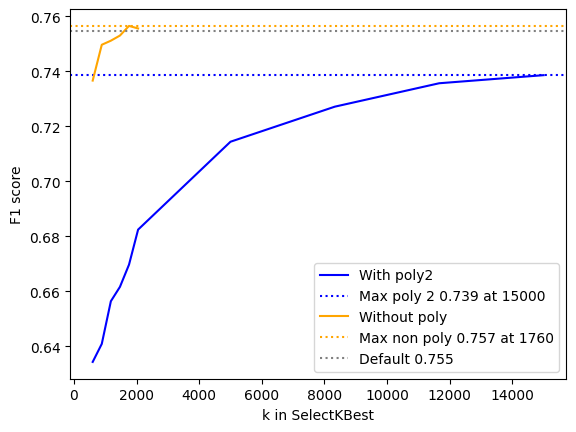

In [73]:
plot_k_range_results(k_range_results_nb)

In [128]:
best_transformations[nb_key] = no_svd_params(nb_key)
best_transformations[nb_key].update({
    'poly2_k_best__poly2': ['passthrough'],
    'poly2_k_best__k_best__k': [1760],
})

### Ridge Classifier

In [74]:
%%time
k_range_results_rc = k_range_scores(complete_pipeline, 
                                    np.concatenate(
                                        (np.linspace(200, 800, 2, dtype=int),
                                         np.linspace(900, 1200, 7, dtype=int),
                                         np.linspace(1500, 4500, 4, dtype=int))),
                                       default_params=no_svd_params(rc_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 13min 35s, sys: 26.5 s, total: 14min 2s
Wall time: 13min 29s


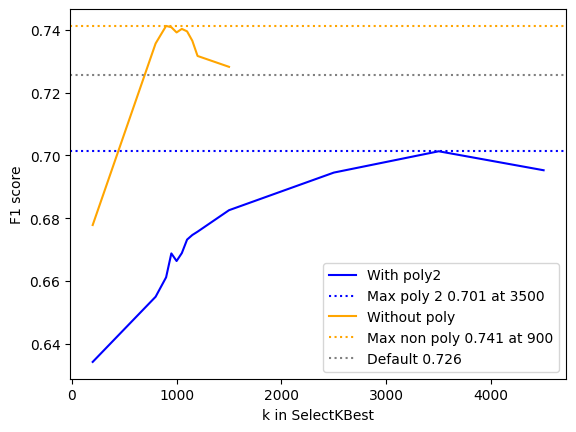

In [75]:
plot_k_range_results(k_range_results_rc)

In [113]:
%%time
svd_range_results_rc = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=900,
                                          poly_2_k=3500,
                                          defaults=best_settings_to_params(rc_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 38min 57s, sys: 21min 57s, total: 1h 54s
Wall time: 26min 10s


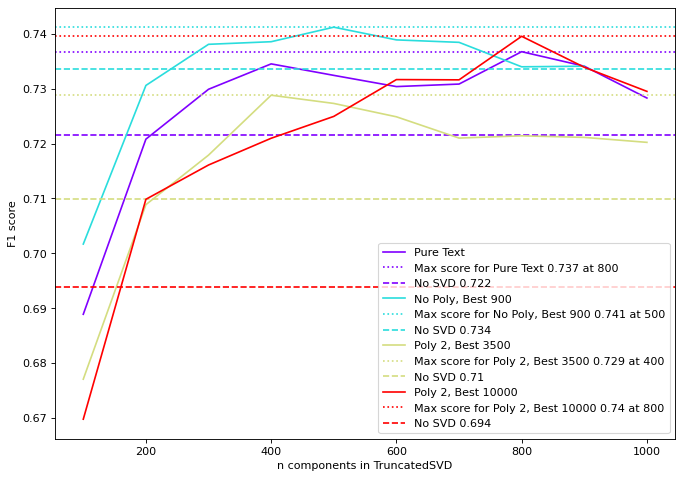

In [114]:
plot_svd__range_results(svd_range_results_rc)

In [129]:
best_transformations[rc_key] = best_settings_to_params(rc_key)
best_transformations[rc_key].update({
    'poly2_k_best__poly2': ['passthrough'],
    'svd__n_components': [500],
    'classifier': [model_rc]
})

### Logistic Regression

In [78]:
no_svd_params(lr_key)

{'vectorizer': ColumnTransformer(transformers=[('text_c_vect', CountVectorizer(min_df=5),
                                  'text'),
                                 ('kw_dict_vect',
                                  Pipeline(steps=[('kw_to_dict',
                                                   FunctionTransformer(func=<function kw_to_dict at 0x7fa2a55ceb90>)),
                                                  ('d_vect', DictVectorizer())]),
                                  'keyword'),
                                 ('loc_dict_vect',
                                  Pipeline(steps=[('kw_to_dict',
                                                   FunctionTransformer(func=<function kw_to_dict at 0x7fa2a55ceb90>)),
                                                  ('d_vect', DictVectorizer())]),
                                  'location')]),
 'vectorizer__text_c_vect__preprocessor': [<function __main__.stem_preprocessor(text)>],
 'vectorizer__text_c_vect__stop_words': [None],
 '

In [82]:
%%time
k_range_results_lr = k_range_scores(complete_pipeline, 
                                    np.concatenate((np.linspace(100, 2000, 5, dtype=int), 
                                                    np.linspace(2500, 4500, 5, dtype=int))),
                                       default_params=no_svd_params(lr_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 8min 39s, sys: 19.4 s, total: 8min 58s
Wall time: 8min 33s


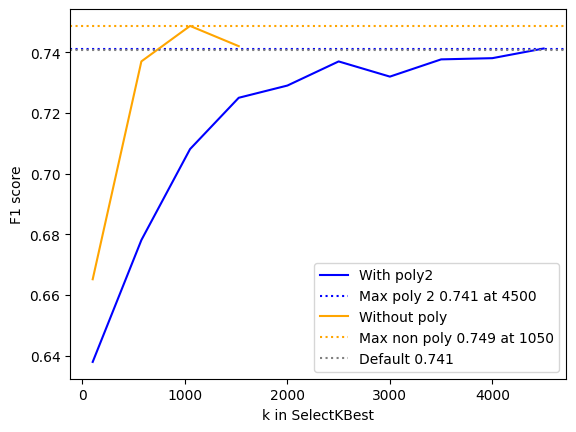

In [83]:
plot_k_range_results(k_range_results_lr)

In [115]:
%%time
svd_range_results_lr = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=1050,
                                          poly_2_k=4500,
                                          defaults=best_settings_to_params(lr_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 41min 59s, sys: 23min 41s, total: 1h 5min 41s
Wall time: 27min 27s


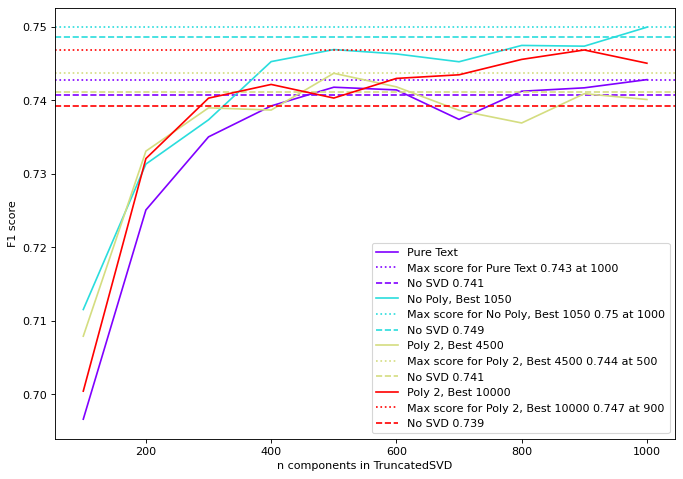

In [116]:
plot_svd__range_results(svd_range_results_lr)

In [130]:
lr_best_transformation = best_settings_to_params(lr_key)
lr_best_transformation.update({
    'poly2_k_best__poly2': ['passthrough'],
    'poly2_k_best__k_best__k': [1050],
    'svd__n_components': [1000]
})

### Decision Tree

In [86]:
%%time
k_range_results_tree = k_range_scores(complete_pipeline, 
                                     np.concatenate(
                                         (np.linspace(100, 180, 5, dtype=int),
                                          np.linspace(200, 800, 4, dtype=int), 
                                          np.linspace(1000, 6000, 4, dtype=int))),
                                       default_params=no_svd_params(tree_key), cv=cv, X=X_full_train, y=y_full_train)


CPU times: user 11min 14s, sys: 26.4 s, total: 11min 40s
Wall time: 11min 7s


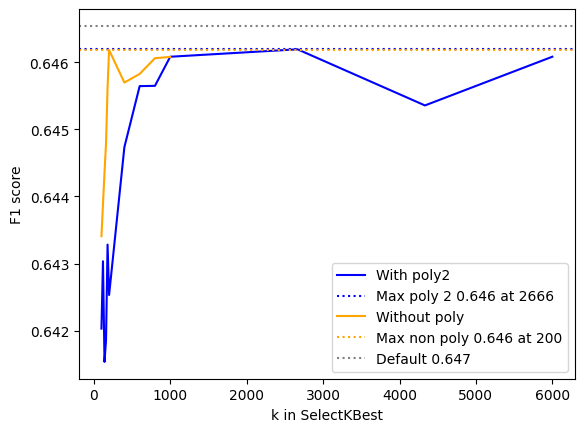

In [87]:
plot_k_range_results(k_range_results_tree)

In [117]:
%%time
svd_range_results_tree = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=200,
                                          poly_2_k=2666,
                                          defaults=best_settings_to_params(tree_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 35min 44s, sys: 14min 37s, total: 50min 22s
Wall time: 25min 49s


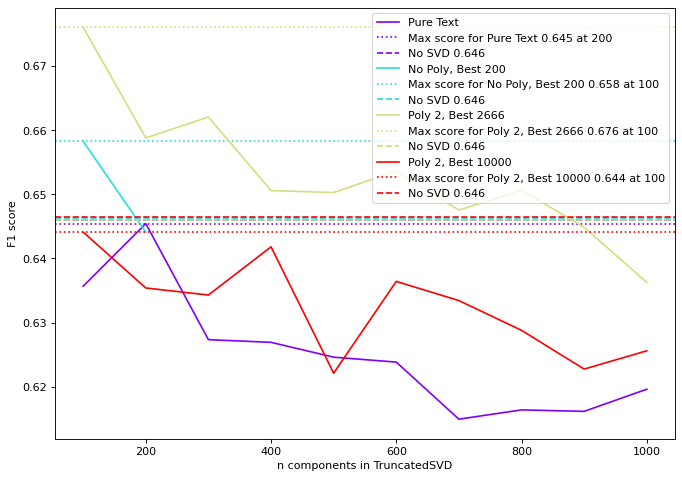

In [118]:
plot_svd__range_results(svd_range_results_tree)

In [131]:
best_transformations[tree_key] = best_settings_to_params(tree_key)
best_transformations[tree_key].update({

    'poly2_k_best__k_best__k': [2666],
    'svd__n_components': [100]    
})

### Random Forest

In [ ]:
%%time
k_range_results_forest = k_range_scores(complete_pipeline, 
                                     np.concatenate((np.linspace(200, 800, 4, dtype=int),
                                                     np.linspace(900, 1300, 5, dtype=int),
                                                     np.linspace(1500, 2400, 3, dtype=int))),
                                       default_params=no_svd_params(forest_key), cv=cv, X=X_full_train, y=y_full_train)

In [ ]:
plot_k_range_results(k_range_results_forest)

In [119]:
%%time
svd_range_results_forest = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=200,
                                          poly_2_k=600,
                                          defaults=best_settings_to_params(forest_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 35min 33s, sys: 13min 34s, total: 49min 8s
Wall time: 26min 28s


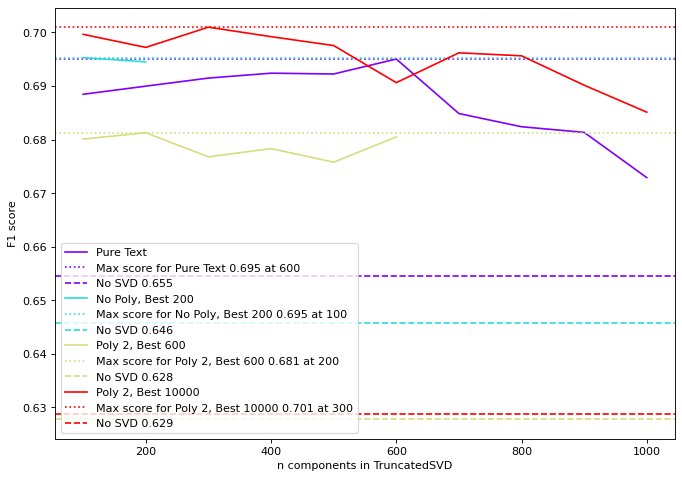

In [120]:
plot_svd__range_results(svd_range_results_forest)

In [132]:
best_transformations[forest_key] = best_settings_to_params(forest_key)
best_transformations[forest_key].update({
    'poly2_k_best__k_best__k': [10000],
    'svd': [300]
})

### XGBoost

In [90]:
%%time
k_range_results_xgb = k_range_scores(complete_pipeline, 
                                     np.concatenate(
                                         (np.linspace(200, 1300, 4, dtype=int), 
                                          np.linspace(1400, 1900, 11, dtype=int),
                                          np.linspace(2000, 3000, 4, dtype=int))),
                                       default_params=no_svd_params(xgb_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 16min 19s, sys: 37.5 s, total: 16min 57s
Wall time: 15min 27s


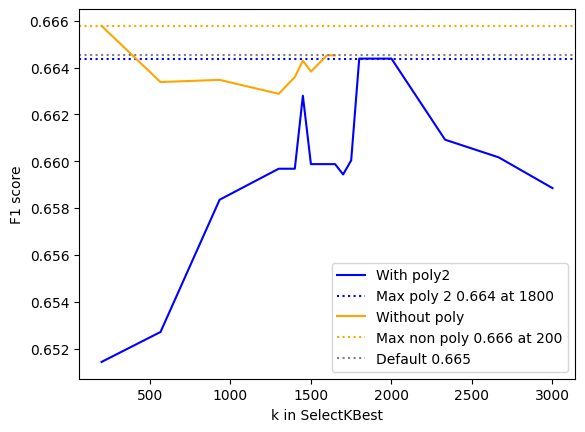

In [91]:
plot_k_range_results(k_range_results_xgb)

In [121]:
%%time
svd_range_results_xgb = svd_n_range_scores(complete_pipeline, 
                                          np.linspace(100, 1000, 10, dtype=int),
                                          no_poly_k=200,
                                          poly_2_k=1800,
                                          defaults=best_settings_to_params(xgb_key), cv=cv, X=X_full_train, y=y_full_train)

CPU times: user 55min 52s, sys: 18min 3s, total: 1h 13min 56s
Wall time: 27min 50s


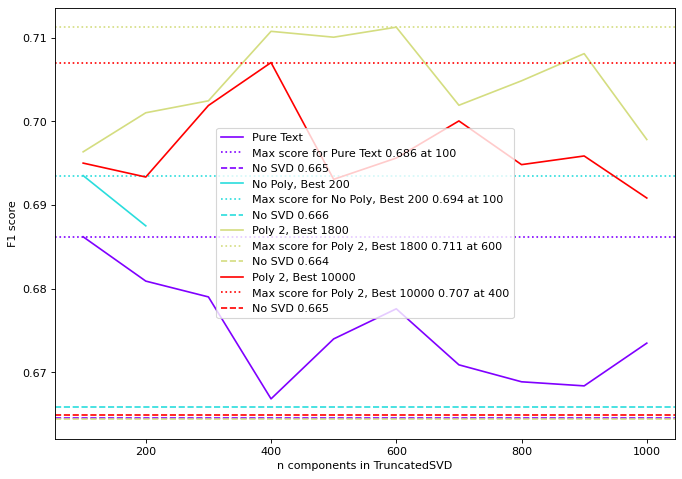

In [122]:
plot_svd__range_results(svd_range_results_xgb)

In [133]:
best_transformations[xgb_key] = best_settings_to_params(xgb_key)
best_transformations[xgb_key].update({
    'poly2_k_best__k_best__k': [1800],
    'svd__n_components': [600]    
})

### Best transformation scores

In [168]:
complete_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'url_cleaner', 'vectorizer', 'poly2_k_best', 'svd', 'classifier', 'url_cleaner__accept_sparse', 'url_cleaner__check_inverse', 'url_cleaner__feature_names_out', 'url_cleaner__func', 'url_cleaner__inv_kw_args', 'url_cleaner__inverse_func', 'url_cleaner__kw_args', 'url_cleaner__validate', 'vectorizer__n_jobs', 'vectorizer__remainder', 'vectorizer__sparse_threshold', 'vectorizer__transformer_weights', 'vectorizer__transformers', 'vectorizer__verbose', 'vectorizer__verbose_feature_names_out', 'vectorizer__text_c_vect', 'vectorizer__kw_dict_vect', 'vectorizer__text_c_vect__analyzer', 'vectorizer__text_c_vect__binary', 'vectorizer__text_c_vect__decode_error', 'vectorizer__text_c_vect__dtype', 'vectorizer__text_c_vect__encoding', 'vectorizer__text_c_vect__input', 'vectorizer__text_c_vect__lowercase', 'vectorizer__text_c_vect__max_df', 'vectorizer__text_c_vect__max_features', 'vectorizer__text_c_vect__min_df', 'vectorizer__text_c_vect__ngram_range', 'vec

In [162]:
from sklearn.pipeline import make_pipeline

def evaluate_pipelines(params_dict=None, feature_key=None):
    record_dict = {'Features': f'{feature_key} (x_val)'}
    test_record_dict = {'Features': f'{feature_key} (test)'}
 
    for model_key, params in params_dict.items():
        pipeline = complete_pipeline
        pipeline.set_params(**params)
        score = cross_val_score(pipeline, X_full_train, y_full_train, scoring='f1', cv=cv)
        
        pipeline.fit(X_full_train, y_full_train)
        test_score = f1_score(y_test, pipeline.predict(X_test))
        
        record_dict[model_key] = score
        test_record_dict[model_key] = test_score    
    scores_df = pd.DataFrame([record_dict, test_record_dict])
    scores_df.set_index('Features', inplace=True)
    return scores_df

In [188]:
params_to_test = best_transformations[nb_key]
params_to_test
best_settings[nb_key]
# best_settings_to_params(nb_key)

{'url_cleaner': FunctionTransformer(func=<function url_clean at 0x7fa2b6728a60>),
 'preprocessor': None,
 'stopwords': None,
 'ngram_range': (1, 1),
 'best_k': None,
 'max_poly': 1,
 'kw': True,
 'loc': False,
 'hashtags': False,
 'svd_n_comp': None}

In [183]:
pipeline1 = Pipeline([
    ('vectorizer', text_vectorizer_transformer),
    ('poly2_k_best', poly2_k_best_pipeline),
    ('svd', TruncatedSVD()),
    ('classifier', LogisticRegression())
])

pipeline1.set_params(
    vectorizer=[text_kw_vectorizer_transformer],
    # poly2_k_best__degree=2,
    svd__n_components=[500],
    classifier=[model_rc]
)
# pipeline1.get_params().keys()

Pipeline(steps=[('vectorizer',
                 [ColumnTransformer(transformers=[('text_c_vect',
                                                   CountVectorizer(min_df=5,
                                                                   stop_words=['i',
                                                                               'me',
                                                                               'my',
                                                                               'myself',
                                                                               'we',
                                                                               'our',
                                                                               'ours',
                                                                               'ourselves',
                                                                               'you',
                                                                               "you're",
                                                                               "you've",
                                                                               "you'll",
                                                                               "you'd",
                                                                               'your',
                                                                               'yours',
                                                                               'yourself',
                                                                               'yourselves',
                                                                               'he',
                                                                               'him',
                                                                               'his',
                                                                               'himself',
                                                                               'she',
                                                                               "she's",
                                                                               'her',
                                                                               'hers',
                                                                               'herself',
                                                                               'it',
                                                                               "it's",
                                                                               'its',
                                                                               'itself', ...]),
                                                   'text...
                                                                    FunctionTransformer(func=<function kw_to_dict at 0x7fa2a55ceb90>)),
                                                                   ('d_vect',
                                                                    DictVectorizer())]),
                                                   'keyword')])]),
                ('poly2_k_best',
                 Pipeline(steps=[('poly2', PolynomialFeatures()),
                                 ('k_best',
                                  SelectKBest(score_func=<function chi2 at 0x7fa2c72d6f80>))])),
                ('svd', TruncatedSVD(n_components=[500])),
                ('classifier',
                 [RidgeClassifier(class_weight='balanced', max_iter=500,
                                  random_state=42)])])

In [175]:
complete_pipeline

Pipeline(steps=[('url_cleaner', [None]),
                ('vectorizer',
                 [ColumnTransformer(transformers=[('text_c_vect',
                                                   CountVectorizer(min_df=5,
                                                                   preprocessor=<function stem_preprocessor at 0x7fa2b6728670>,
                                                                   stop_words=['i',
                                                                               'me',
                                                                               'my',
                                                                               'myself',
                                                                               'we',
                                                                               'our',
                                                                               'ours',
                                                                               'ourselves',
                                                                               'you',
                                                                               "you're",
                                                                               "you've",
                                                                               "you'll",
                                                                               "you'd",
                                                                               'your',
                                                                               'yours',
                                                                               'yourself',
                                                                               'yourselves',
                                                                               'he',
                                                                               'him',
                                                                               'his',
                                                                               'himself',
                                                                               'she',
                                                                               "she's",
                                                                               'her',
                                                                               'hers',
                                                                               'herself',
                                                                               'it',
                                                                               "it's",
                                                                               'its',
                                                                               'itself', ...]),
                                                   'text')])]),
                ('poly2_k_best',
                 Pipeline(steps=[('poly2', PolynomialFeatures()),
                                 ('k_best',
                                  SelectKBest(score_func=<function chi2 at 0x7fa2c72d6f80>))])),
                ('svd', ['passthrough']), ('classifier', [ComplementNB()])])

In [171]:
complete_pipeline.get_params().keys()
complete_pipeline.fit(X_full_train, y_full_train, **(best_transformations[nb_key]))

ValueError: Pipeline.fit does not accept the vectorizer parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

In [163]:
transformation_steps_df = evaluate_pipelines(params_dict=best_transformations, feature_key='Data transformation')
pd.concat((default_scores_df, preparation_scores_df, transformation_steps_df))

AttributeError: 'list' object has no attribute 'set_params'

## Final Models Parameters Tuning

In [510]:
def grid_search(pipe, param_grid, X, y):
    gs = GridSearchCV(pipe, 
                               param_grid = param_grid,
                               scoring='f1',
                               cv=cv) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gs.fit(X, y)
    print("Tuned Hyperparameters :", gs.best_params_)
    print(f"F1 score : {gs.best_score_}")
    print("________________________")
    return gs

In [511]:
def tune_params(pipe, best_transformation, tuning_grid):
    tuning_grid.update(best_transformation)
    return grid_search(pipe, tuning_grid, X_full_train, y_full_train)

### Naive Bayes

In [512]:
%%time

nb_tuning_grid = {
    'vectorizer__text_c_vect__min_df': [3, 5, 10],
    'classifier__alpha': np.logspace(-3,2,6)
}

nb_tuning_results = tune_params(complete_pipeline, nb_tuning_grid, nb_best_transformation)

Tuned Hyperparameters : {'classifier': ComplementNB(alpha=0.1), 'classifier__alpha': 0.1, 'poly2_k_best__k_best__k': 1760, 'poly2_k_best__poly2': 'passthrough', 'svd': 'passthrough', 'vectorizer__text_c_vect__min_df': 5}
F1 score : 0.7576974909184092
________________________
CPU times: user 5.06 s, sys: 0 ns, total: 5.06 s
Wall time: 5.06 s


In [513]:
%%time
rc_tuning_grid = {
    'classifier__alpha': np.logspace(-3,2,6),
    'classifier__solver': ['lsqr', 'saga', 'sag'],
}

rc_tuning_results = tune_params(complete_pipeline, rc_tuning_grid, rc_best_transformation)

Tuned Hyperparameters : {'classifier': RidgeClassifier(alpha=10.0, class_weight='balanced', max_iter=500,
                random_state=42, solver='lsqr'), 'classifier__alpha': 10.0, 'classifier__solver': 'lsqr', 'poly2_k_best': 'passthrough', 'svd__n_components': 600, 'url_cleaner': None, 'vectorizer__text_c_vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during',

In [517]:
%%time

lr_tuning_grid = {
    'classifier__C': np.logspace(-3,2,6),
    'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
}

lr_tuning_results = tune_params(complete_pipeline, lr_tuning_grid, lr_best_transformation)

Tuned Hyperparameters : {'classifier': LogisticRegression(max_iter=500, random_state=42, solver='sag'), 'classifier__C': 1.0, 'classifier__solver': 'sag', 'poly2_k_best__k_best__k': 1525, 'poly2_k_best__poly2': 'passthrough', 'svd__n_components': 900, 'url_cleaner': None}
F1 score : 0.7571394305892067
________________________
CPU times: user 22min 36s, sys: 18min, total: 40min 36s
Wall time: 10min 9s


In [540]:
%%time

tree_tuning_grid = {
    'classifier__criterion': ['gini', 'enthropy'],
    'classifier__max_depth': range(12, 19),
    'classifier__min_samples_split': range(1, 4),
    'classifier__min_samples_leaf': range(5, 10)
}

tree_tuning_results = tune_params(complete_pipeline, tree_tuning_grid, tree_best_transformation)

Tuned Hyperparameters : {'classifier': DecisionTreeClassifier(max_depth=18, min_samples_leaf=8), 'classifier__criterion': 'gini', 'classifier__max_depth': 18, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2, 'poly2_k_best__k_best__k': 200, 'poly2_k_best__poly2': 'passthrough', 'svd__n_components': 100, 'url_cleaner': None, 'vectorizer': ColumnTransformer(transformers=[('text_c_vect',
                                 CountVectorizer(min_df=5,
                                                 preprocessor=<function stem_preprocessor at 0x7f3d3aed8280>,
                                                 stop_words=['i', 'me', 'my',
                                                             'myself', 'we',
                                                             'our', 'ours',
                                                             'ourselves', 'you',
                                                             "you're", "you've",
                             

In [542]:
%%time

forest_tuning_grid =  {
    'classifier__max_depth': [60, 80, 100, 120, 140],
    'classifier__max_features': [3, 4, 5, 6, 7],
    'classifier__min_samples_leaf': [1, 2, 3, 4],
    'classifier__min_samples_split': [8, 10, 12, 14, 16],
    'classifier__n_estimators': [50, 70, 90, 110]
}

forest_tuning_results = tune_params(complete_pipeline, forest_tuning_grid, forest_best_transformation)

Tuned Hyperparameters : {'classifier': RandomForestClassifier(max_depth=140, max_features=7, min_samples_split=16,
                       n_estimators=50, random_state=42), 'classifier__max_depth': 140, 'classifier__max_features': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 16, 'classifier__n_estimators': 50, 'poly2_k_best': 'passthrough', 'svd': 'passthrough', 'url_cleaner': None, 'vectorizer': ColumnTransformer(transformers=[('text_c_vect',
                                 CountVectorizer(min_df=5,
                                                 preprocessor=<function stem_preprocessor at 0x7f3d3aed8280>,
                                                 stop_words=['i', 'me', 'my',
                                                             'myself', 'we',
                                                             'our', 'ours',
                                                             'ourselves', 'you',
                                             

In [514]:
%%time

xgb_tuning_grid = {
    'classifier__learning_rate': [0.15, 0.2, 0.25],
    'classifier__n_estimators': [200, 400, 500],
    'classifier__max_depth': [2, 3, 5]
}

xgb_tuning_results = tune_params(complete_pipeline, xgb_tuning_grid, xgb_best_transformation)

Tuned Hyperparameters : {'classifier': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.15, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...), 'classifier__learning_rate': 0.15, 'classifier__max_depth': 2, 'classifier__n_estimators': 200, 'poly2_k_best__k_best__k': 1550, 'svd__n_components': 600, 'url_cleaner': None, 'vectorizer': ColumnTransformer(transformers=[('text_c_vect',
              

## Train and test winner models

In [79]:
%%time
train_data_sag = prepare_data_tkl_poly(df_full_train, svd_n_components=1000)
test_data_sag = prepare_test_data_tkl_poly(df_test, train_data_sag)

CPU times: user 1h 23min 39s, sys: 16min 1s, total: 1h 39min 40s
Wall time: 1h 38min 10s


In [80]:
stemmer.stem('blown')

'blown'

In [81]:
%%time
model_lr_sag = LogisticRegression(solver="sag", C=1.0, max_iter=1000, random_state=42)
model_lr_sag.fit(train_data_sag['vectors'], df_full_train.target)
f1_score(df_test.target, model_lr_sag.predict(test_data_sag))

CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.4 s


/home/iliav/Documents/workspaces/twitter-disaster-dea/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.7613542526837325

In [82]:
%%time
train_data_rc = prepare_data_tkl_poly(df_full_train, svd_n_components=700)
test_data_rc = prepare_test_data_tkl_poly(df_test, train_data_rc)

CPU times: user 2min 44s, sys: 29.8 s, total: 3min 14s
Wall time: 2min 10s


In [83]:
%%time
model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
model_rc.fit(train_data_rc['vectors'], df_full_train.target)
f1_score(df_test.target, model_rc.predict(test_data_rc))

CPU times: user 58.9 ms, sys: 235 ms, total: 294 ms
Wall time: 77.1 ms


0.7491909385113268

Stemmer + stopwords: 0.76, 0.75

Stemmer: 0.76, 0.75

Stopwords: 0.75, 0.74

Plain: 0.74, 0.75

Lemma: 0.75, 0.74

In [85]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model_lr = LogisticRegression(max_iter=500, random_state=42)
grids_lr = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr[scoring] = clf

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8213453718411428
________________________
Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
f1 : 0.7749059682772194
________________________
Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
roc_auc : 0.880072438164868
________________________
CPU times: user 44min 28s, sys: 6min 32s, total: 51min 1s
Wall time: 38min 41s


In [86]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']
parameters = {
    'alpha': [0.1, 0.5, 1, 2, 3, 4],
    'solver': ['lsqr', 'saga', 'sag'],
}

model_rc = RidgeClassifier(random_state=42, max_iter=500, class_weight="balanced")
grids_rc = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_rc,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_rc['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_rc[scoring] = clf

Tuned Hyperparameters : {'alpha': 0.5, 'solver': 'saga'}
accuracy : 0.8164196943407395
________________________
Tuned Hyperparameters : {'alpha': 2, 'solver': 'sag'}
f1 : 0.7745214652653776
________________________
Tuned Hyperparameters : {'alpha': 4, 'solver': 'saga'}
roc_auc : 0.8777037458819706
________________________
CPU times: user 21min 22s, sys: 1min 20s, total: 22min 43s
Wall time: 20min 5s


In [92]:
pd.DataFrame(grids_rc['accuracy'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.805582,0.009981
1,0.1,saga,0.816255,0.008197
2,0.1,sag,0.814121,0.008179
3,0.5,lsqr,0.805582,0.009981
4,0.5,saga,0.816420,0.008249
5,0.5,sag,0.814121,0.008179
6,1,lsqr,0.806074,0.009921
7,1,saga,0.816255,0.008197
8,1,sag,0.814121,0.008179
9,2,lsqr,0.806731,0.008809


In [93]:
pd.DataFrame(grids_rc['f1'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.764547,0.015062
1,0.1,saga,0.773567,0.012115
2,0.1,sag,0.772884,0.012035
3,0.5,lsqr,0.764547,0.015062
4,0.5,saga,0.773725,0.012135
5,0.5,sag,0.772884,0.012035
6,1,lsqr,0.764989,0.015170
7,1,saga,0.773475,0.012106
8,1,sag,0.772794,0.012061
9,2,lsqr,0.765753,0.014674


In [94]:
pd.DataFrame(grids_rc['roc_auc'].cv_results_)[['param_alpha', 'param_solver', 'mean_test_score', 'std_test_score']]

,param_alpha,param_solver,mean_test_score,std_test_score
0,0.1,lsqr,0.867089,0.013634
1,0.1,saga,0.877488,0.011419
2,0.1,sag,0.875830,0.012074
3,0.5,lsqr,0.867272,0.013593
4,0.5,saga,0.877515,0.011381
5,0.5,sag,0.875883,0.012060
6,1,lsqr,0.867473,0.013526
7,1,saga,0.877542,0.011338
8,1,sag,0.875950,0.012024
9,2,lsqr,0.867985,0.013486


In [1]:
%%time
scorings_list = ['accuracy', 'f1', 'roc_auc']

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']
}

model_lr_big = LogisticRegression(max_iter=1000, random_state=42)
grids_lr_big = {}
for scoring in scorings_list:
    clf = GridSearchCV(model_lr,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=cv) 
    clf.fit(train_data_sag['vectors'], df_full_train.target)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")
    grids_lr_big[scoring] = clf

NameError: name 'LogisticRegression' is not defined

In [96]:
current_time = datetime.now().strftime("%H:%M:%S")
print("Time finished =", current_time)

Time finished = 18:58:05
